In [1]:
# Con este Notebook se realizará la carga y procesado de registros logs de la arquitectura
#   de microservicios desarrollada en docker para el sistema de información ADSB
#   Se extrae la información de uso de CPU de los contenedores en cada test, se especifican los de interés y se analizan

In [2]:
# Importación de librerías necesarias
import os
import re
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Configuración previa para tratar los archivos

carpeta_logs = "./recursos_test/"  
contenedores_objetivo = ["redis", "kafka"]  # Nombres que aparecen en la columna NAME
regex_cpu = re.compile(r'(?P<id>\S+)\s+(?P<name>\S+)\s+(?P<cpu>\d+\.\d+)%')

# Tamaño del intervalo (número de muestras por bloque)
tam_bloque = 2

In [4]:
# Función auxiliar para procesar las métricas de interes
def extraer_cpu_por_contenedor(archivo):
    with open(archivo, 'r') as f:
        lineas = f.readlines()

    datos = {nombre: [] for nombre in contenedores_objetivo}
    bloque = []

    for linea in lineas:
        if "CONTAINER ID" in linea:
            if bloque:
                for l in bloque:
                    match = regex_cpu.search(l)
                    if match:
                        name = match.group('name')
                        cpu = float(match.group('cpu'))
                        if name in contenedores_objetivo:
                            datos[name].append(cpu)
                bloque = []
        else:
            bloque.append(linea)

    # Último bloque
    for l in bloque:
        match = regex_cpu.search(l)
        if match:
            name = match.group('name')
            cpu = float(match.group('cpu'))
            if name in contenedores_objetivo:
                datos[name].append(cpu)

    return datos


In [5]:
# Carga de archivos, proceso para separar las líneas de interés y almacenarlas 

archivos = sorted([f for f in os.listdir(carpeta_logs) if f.startswith("recursos") and f.endswith(".log")])
resultados = {nombre: {} for nombre in contenedores_objetivo}

for archivo in archivos:
    test_id = os.path.splitext(archivo)[0]  # e.g., 'recursos1'
    datos = extraer_cpu_por_contenedor(os.path.join(carpeta_logs, archivo))
    for nombre in contenedores_objetivo:
        resultados[nombre][test_id] = datos.get(nombre, [])

8.807301587301588
9.160327868852459
8.5015
10.536393442622952
11.5385
18.139322033898306
17.643103448275863
14.327499999999999


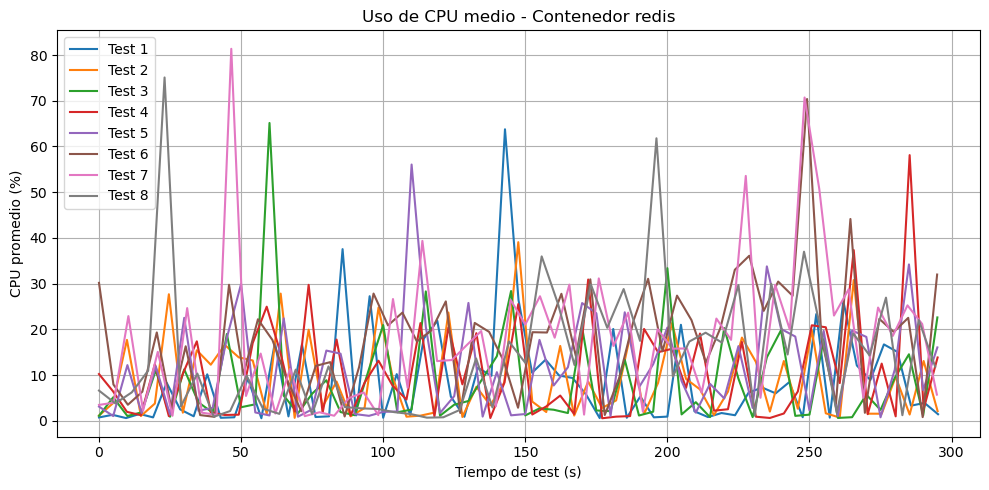

270.93857142857144
274.96295081967213
276.5505
258.78131147540984
199.1415
168.05186440677966
137.86775862068964
107.17134615384614


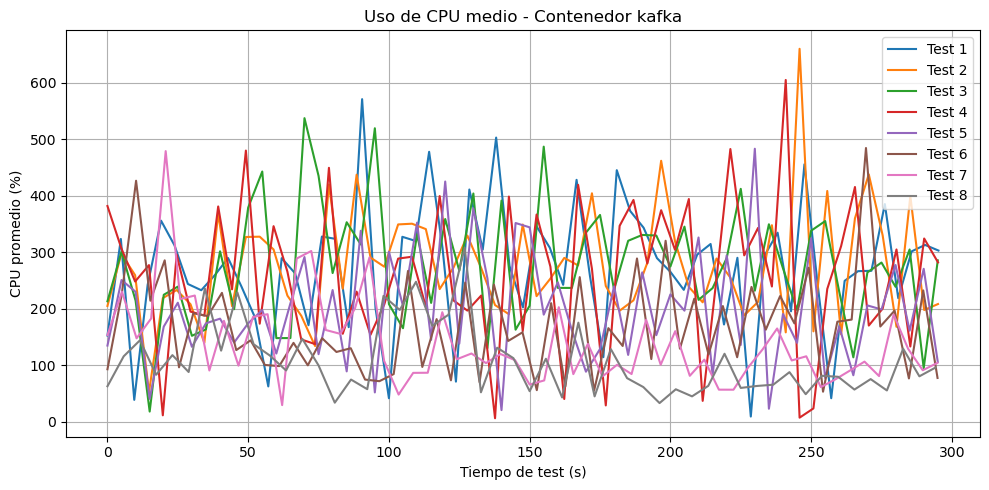

In [6]:
# Agrupar la información y presentarla gráficamente
# Se realiza un escalado de las muestras adapatada al tiempo de test, según TEST.sh es de 300 segundos

for nombre in contenedores_objetivo:
    plt.figure(figsize=(10, 5))
    for test_id, valores in resultados[nombre].items():

        # Agrupar en bloques y calcular medias
        test_num = int(re.search(r'recursos(\d+)', test_id).group(1))
        escala_muestras=300/len(valores)
        eje_x = [i * escala_muestras for i in range(len(valores))]
        plt.plot(eje_x, valores, label=f"Test {test_num}")
        print (sum(valores) / len(valores))
        
    plt.title(f"Uso de CPU medio - Contenedor {nombre}")
    plt.xlabel(f"Tiempo de test (s)")
    plt.ylabel("CPU promedio (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
